# Data preparation and preprocessing

In [ ]:
import pandas as pd

#Load gdp data and deforestation data
deforestation_file = "brazil_deforestration_by_state_formatted.csv"
gdp_file = "PIB dos Municípios - base de dados 2010-2020.xls"
gdp_file1 = 'PIB dos Municípios - base de dados 2002-2009.xls'
deforestation_data = pd.read_csv(deforestation_file)
gdp_data = pd.read_excel(gdp_file)
gdp_data1 = pd.read_excel(gdp_file1)

In [ ]:
#Concatanate the two dataframes
concat_df = pd.concat([gdp_data, gdp_data1], axis=0)

In [ ]:
#Merge gdp data into the deforestation data
muns = deforestation_data.geocode_ibge.unique()
list = []

for mun in muns:
  for year in range(2010,2021):
    deforestation_data.loc[(deforestation_data['year']==year)&(deforestation_data['geocode_ibge']==mun),'GDP'] = gdp_data.loc[(gdp_data['Ano']==year)&(gdp_data['Código do Município']==mun), 'GDP']

In [ ]:
#Merge data from 2002 to 2020
merged_data = pd.merge(deforestation_data, concat_df, left_on=['geocode_ibge', 'year'], right_on=['Código do Município', 'Ano'], how='left')

In [ ]:
columns = gdp_data.columns

for col in columns:
  if col not in ('gdp','gdp_per_capita'):
    merged_data = merged_data.drop(columns=col)

In [ ]:
merged_data.isnull().sum()

In [ ]:
merged_data.to_csv(deforestation_file)

In [ ]:
municipallities = merged_data['municipality'].unique()
years = range(2008,2021)

In [ ]:
from pandas._libs.tslibs.timedeltas import parse_timedelta_unit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

model = LinearRegression()

#Imputing gdp using linear regression
for mun in municipallities:
  data = merged_data.loc[merged_data['municipality']==mun, 'gdp']
  x = np.array(years)
  y = np.array(data[0:13])
  model.fit(x.reshape(-1,1), y)
  merged_data.loc[(merged_data['year']==2021) & (merged_data['municipality']==mun), 'gdp'] = model.predict([[2021]])[0]
  merged_data.loc[(merged_data['year']==2022) & (merged_data['municipality']==mun), 'gdp'] = model.predict([[2022]])[0]

#Imputing gdp_per_capita using linear regression
for mun in municipallities:
  data = merged_data.loc[merged_data['municipality']==mun, 'gdp_per_capita']
  x = np.array(years)
  y = np.array(data[0:13])
  model.fit(x.reshape(-1,1), y)
  merged_data.loc[(merged_data['year']==2021) & (merged_data['municipality']==mun), 'gdp_per_capita'] = model.predict([[2021]])[0]
  merged_data.loc[(merged_data['year']==2022) & (merged_data['municipality']==mun), 'gdp_per_capita'] = model.predict([[2022]])[0]

#Ensemble model building

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
data = pd.read_csv("brazil_deforestration_by_state_formatted.csv")

In [2]:
data.year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

In [4]:
data.corr()

,index,year,areakm,geocode_ibge,deforestation_increment(areakm),gdp,gdp_per_capita
index,1.000000,2.254011e-03,0.212359,2.174975e-01,-0.003077,-0.036087,0.257095
year,0.002254,1.000000e+00,0.035486,-7.702218e-14,0.079713,0.057419,0.325906
areakm,0.212359,3.548599e-02,1.000000,3.495719e-01,0.523478,0.097106,0.305398
geocode_ibge,0.217497,-7.702218e-14,0.349572,1.000000e+00,0.022013,-0.021672,0.453395
deforestation_increment(areakm),-0.003077,7.971260e-02,0.523478,2.201250e-02,1.000000,0.083388,0.075659
gdp,-0.036087,5.741937e-02,0.097106,-2.167226e-02,0.083388,1.000000,0.155684
gdp_per_capita,0.257095,3.259056e-01,0.305398,4.533948e-01,0.075659,0.155684,1.000000


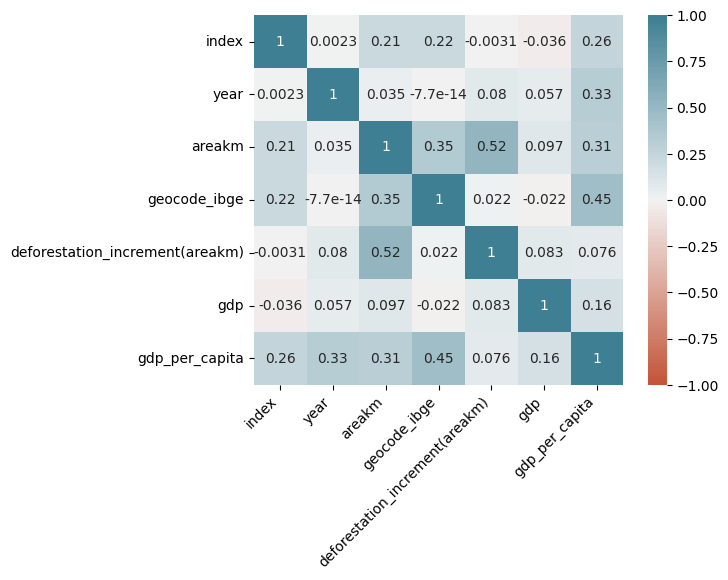

In [3]:
import seaborn as sns
corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
data = data.drop(columns=['index','geocode_ibge'])
data = pd.get_dummies(data=data,columns=['state','municipality'])

In [ ]:
#Subsetting dataset
data_holdout = data.loc[data['year'].isin([2020,2021,2022])]
data_rest = data.loc[~data['year'].isin([2020,2021,2022])]

# Taking the data related to years except for the later 3 for grid search
data_rest_base = data_rest.loc[~data_rest['year'].isin([2017,2018,2019])]
# Taking the data related to later 3 for ols
data_rest_meta = data_rest.loc[data_rest['year'].isin([2017,2018,2019])]

In [ ]:
data_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 12 to 6224
Columns: 425 entries, year to municipality_Ze Doca
dtypes: float64(4), int64(1), uint8(420)
memory usage: 569.0 KB


In [ ]:
y_test = data_holdout.pop('deforestation_increment(areakm)')

In [ ]:
y_meta = data_rest_meta.pop('deforestation_increment(areakm)')
x_meta = data_rest_meta

y_base = data_rest_base.pop('deforestation_increment(areakm)')
x_base = data_rest_base

In [ ]:
x_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 9 to 6221
Columns: 424 entries, year to municipality_Ze Doca
dtypes: float64(3), int64(1), uint8(420)
memory usage: 559.3 KB


In [ ]:
x_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3735 entries, 0 to 6218
Columns: 424 entries, year to municipality_Ze Doca
dtypes: float64(3), int64(1), uint8(420)
memory usage: 1.6 MB


In [ ]:
from sklearn.preprocessing import StandardScaler

#Scale the data
scaler = StandardScaler()
x_base = scaler.fit_transform(x_base)
x_meta = scaler.transform(x_meta)
x_test = scaler.transform(data_holdout)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

#Lasso regression model
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=8)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

#These splits are used to find the best GS hyper-parameters
time_split_inner = TimeSeriesSplit(n_splits = 3)

#Run grid search to find best parameters for lasso regression
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error')
gs_las.fit(x_base, y_base)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=8),
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error')

In [ ]:
from sklearn.neural_network import MLPRegressor

#Multi-Layer Perceptron
mlp = MLPRegressor(early_stopping=True, max_iter=1000, random_state=8)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}

#Run grid search to find best parameters for MLP regressor
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_mlp.fit(x_base, y_base)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(early_stopping=True, max_iter=1000,
                                    random_state=8),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
from sklearn.svm import LinearSVR

#Linear Support Vector Regression
svr = LinearSVR(loss='squared_epsilon_insensitive', max_iter=1000, random_state=8)

svr_params = {'epsilon': [8, 9, 10, 11, 12, 13, 14],
              'fit_intercept': [0, 1],
              'C': [33, 34, 35, 36, 37, 38, 39, 40, 41]}

#Run grid search to find best parameters for LinearSVR
gs_svr = GridSearchCV(svr, svr_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_svr.fit(x_base, y_base)              

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearSVR(loss='squared_epsilon_insensitive',
                                 random_state=8),
             n_jobs=-1,
             param_grid={'C': [33, 34, 35, 36, 37, 38, 39, 40, 41],
                         'epsilon': [8, 9, 10, 11, 12, 13, 14],
                         'fit_intercept': [0, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
from sklearn.svm import SVR

# Support Vector Machine
svm = SVR(C=0.1, max_iter=1000)

svm_params = {'kernel': ['rbf', 'sigmoid', 'poly'],
              'gamma': ['scale', 'auto', 0.2], 
              'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]}

#Run grid search to find best parameters for SVR
gs_svm = GridSearchCV(svm, svm_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_svm.fit(x_base, y_base)              

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(C=0.1, max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': ['scale', 'auto', 0.2],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest Regressor
rf = RandomForestRegressor(random_state=8)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

#Run grid search to find best parameters for RandomForest Regressor
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs_rf.fit(x_base, y_base)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=8), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
gs_las.best_params_

{'alpha': 0.1, 'fit_intercept': 1}

In [ ]:
gs_mlp.best_params_

{'activation': 'relu', 'alpha': 1e-06, 'hidden_layer_sizes': (24, 12)}

In [ ]:
gs_svr.best_params_

{'C': 33, 'epsilon': 14, 'fit_intercept': 0}

In [ ]:
gs_svm.best_params_

{'C': 0.2, 'gamma': 0.2, 'kernel': 'sigmoid'}

In [ ]:
gs_rf.best_params_

{'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 300}

In [ ]:
est_meta = pd.DataFrame(y_meta)

In [ ]:
# The predictions of the base models on the meta-training set, which will be used to train the meta model
est_meta['lasso'] = gs_las.predict(x_meta)
est_meta['mlp'] = gs_mlp.predict(x_meta)
est_meta['svr'] = gs_svr.predict(x_meta)
est_meta['svm'] = gs_svm.predict(x_meta)
est_meta['random_forest'] = gs_rf.predict(x_meta)

In [ ]:
y_meta = est_meta.pop('deforestation_increment(areakm)')

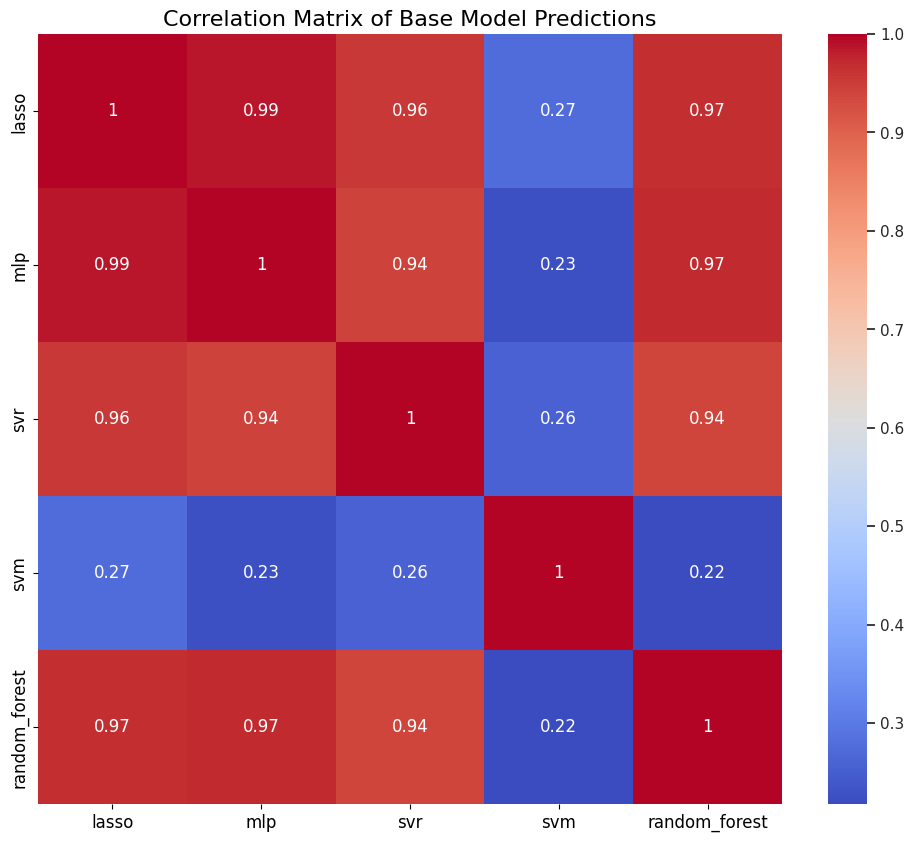

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale=1.0)
sns.heatmap(est_meta.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Base Model Predictions", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Setting Linear Regression as the final stage meta model
meta = LinearRegression()
# Fitting the meta model to the predictions of the base models on the meta-training set, and y_meta
meta.fit(est_meta, y_meta)

LinearRegression()

In [ ]:
y_test

12      12.937556
13      38.265312
14      18.502625
27      18.174810
28      17.649864
          ...    
6208     1.941244
6209     0.000000
6222     0.582180
6223     1.062286
6224     1.269176
Name: deforestation_increment(areakm), Length: 1245, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

def reg_scoring(x, y, meta, reg_dict):  
    mae_scores = []
    mse_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        pred_y = reg.predict(x)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        mae_scores.append(round(mean_absolute_error(y, pred_y), 4))
        mse_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': mae_scores,
                            'Root Mean Squared Error': mse_scores
                            })
    
    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred)

    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add deforestation_increment(areakm) variable to the DataFrame of predictions
    df_pred['deforestation_increment(areakm)'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [ ]:
# Dictionary of TRAINED base models
reg_dict = {
    'lasso': gs_las,
    'mlp': gs_mlp, 
    'svr': gs_svr,
    'svm': gs_svm,
    'random_forest': gs_rf
}

In [ ]:
scores, data_pred = reg_scoring(x_test, y_test, meta, reg_dict)

In [ ]:
data_pred['deforestation_increment(areakm)']

0       12.937556
1       38.265312
2       18.502625
3       18.174810
4       17.649864
          ...    
1240     1.941244
1241     0.000000
1242     0.582180
1243     1.062286
1244     1.269176
Name: deforestation_increment(areakm), Length: 1245, dtype: float64

In [ ]:
scores

,Model,Mean Absolute Error,Root Mean Squared Error
0,lasso,11.0522,40.4272
1,mlp,11.0825,39.2084
2,svr,22.2282,29.7057
3,svm,18.6302,55.5488
4,random_forest,10.3567,37.4177
5,Stack Model,9.2552,28.3874


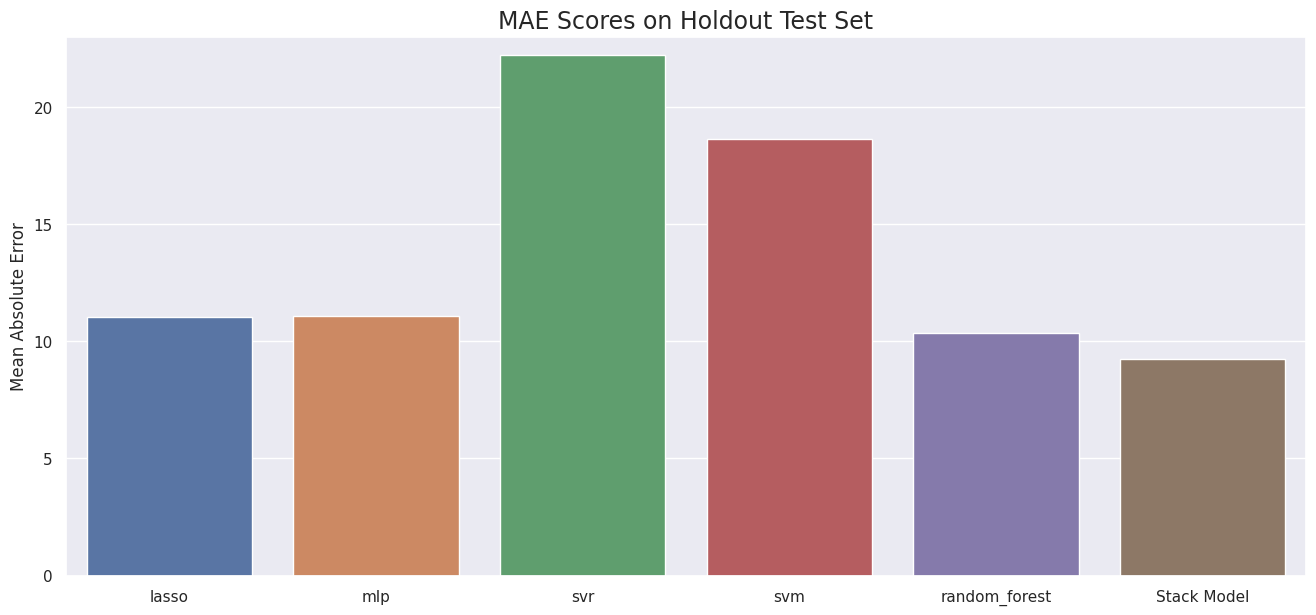

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Mean Absolute Error', data=scores, ax=ax)
ax.set(ylim=(0, 23))

ax.set_ylabel('Mean Absolute Error', size=12)
ax.set_xlabel('')
plt.title('MAE Scores on Holdout Test Set', fontsize=17);

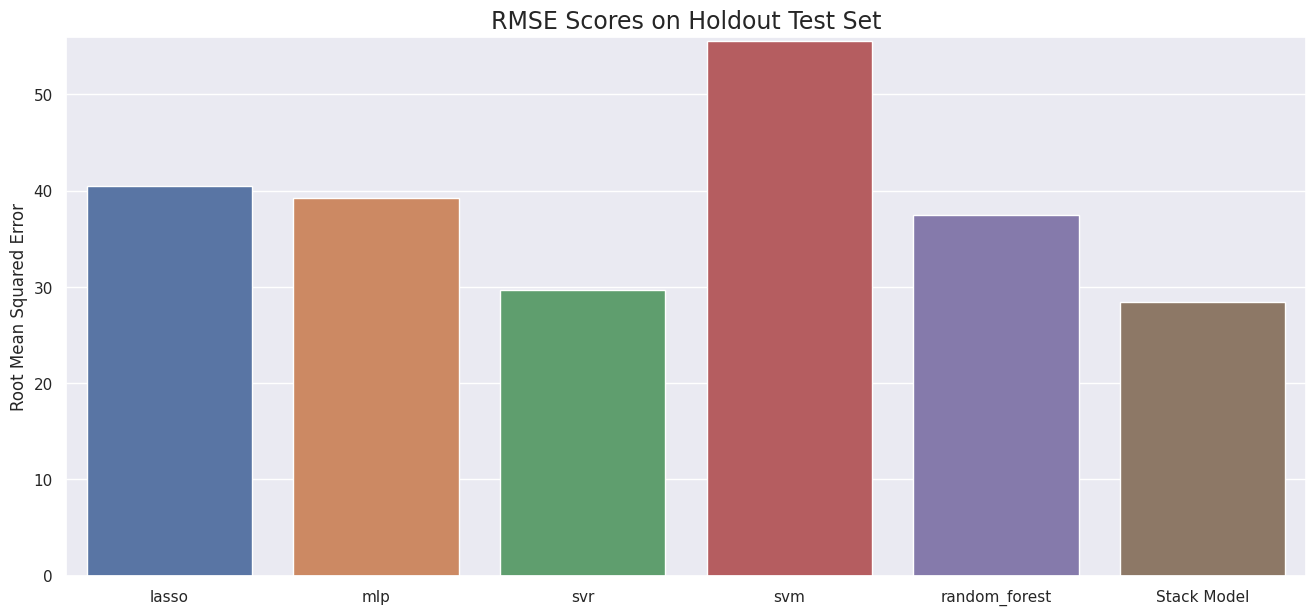

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))

sns.barplot(x='Model', y='Root Mean Squared Error', data=scores, ax=ax)
ax.set(ylim=(0, 56))

ax.set_ylabel('Root Mean Squared Error', size=12)
ax.set_xlabel('')
plt.title('RMSE Scores on Holdout Test Set', fontsize=17);

In [ ]:
data_pred.index = data_holdout.index

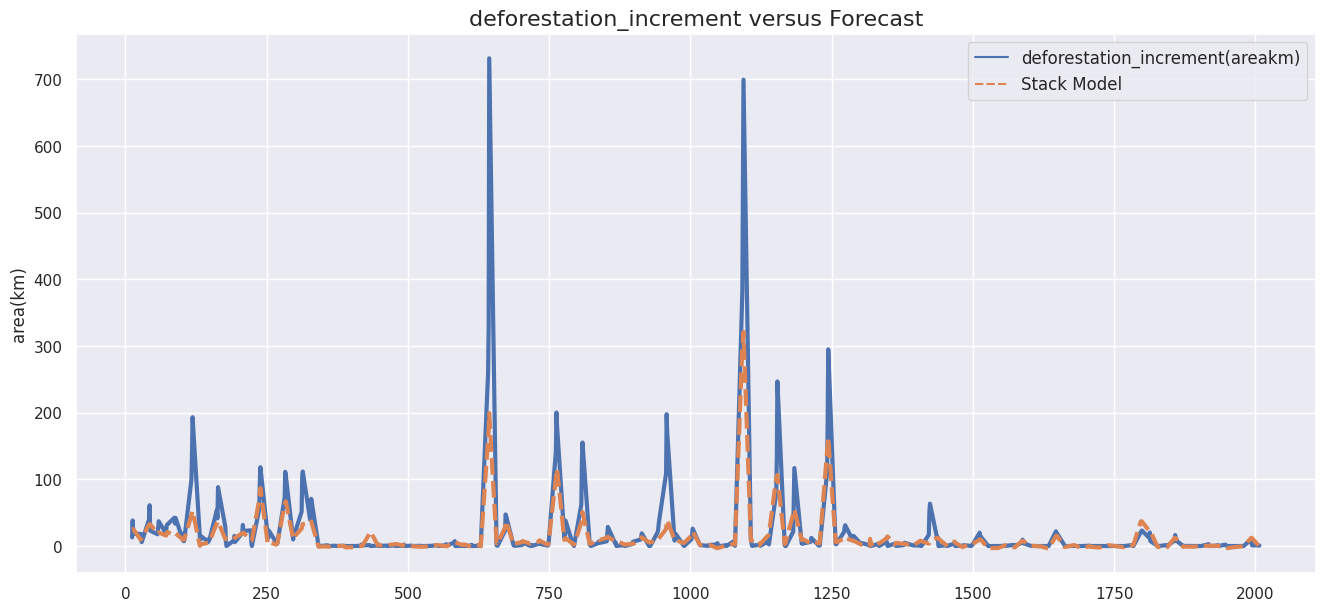

In [ ]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=data_pred[['deforestation_increment(areakm)', 'Stack Model']].iloc[:400], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('deforestation_increment versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('area(km)', fontsize=12);